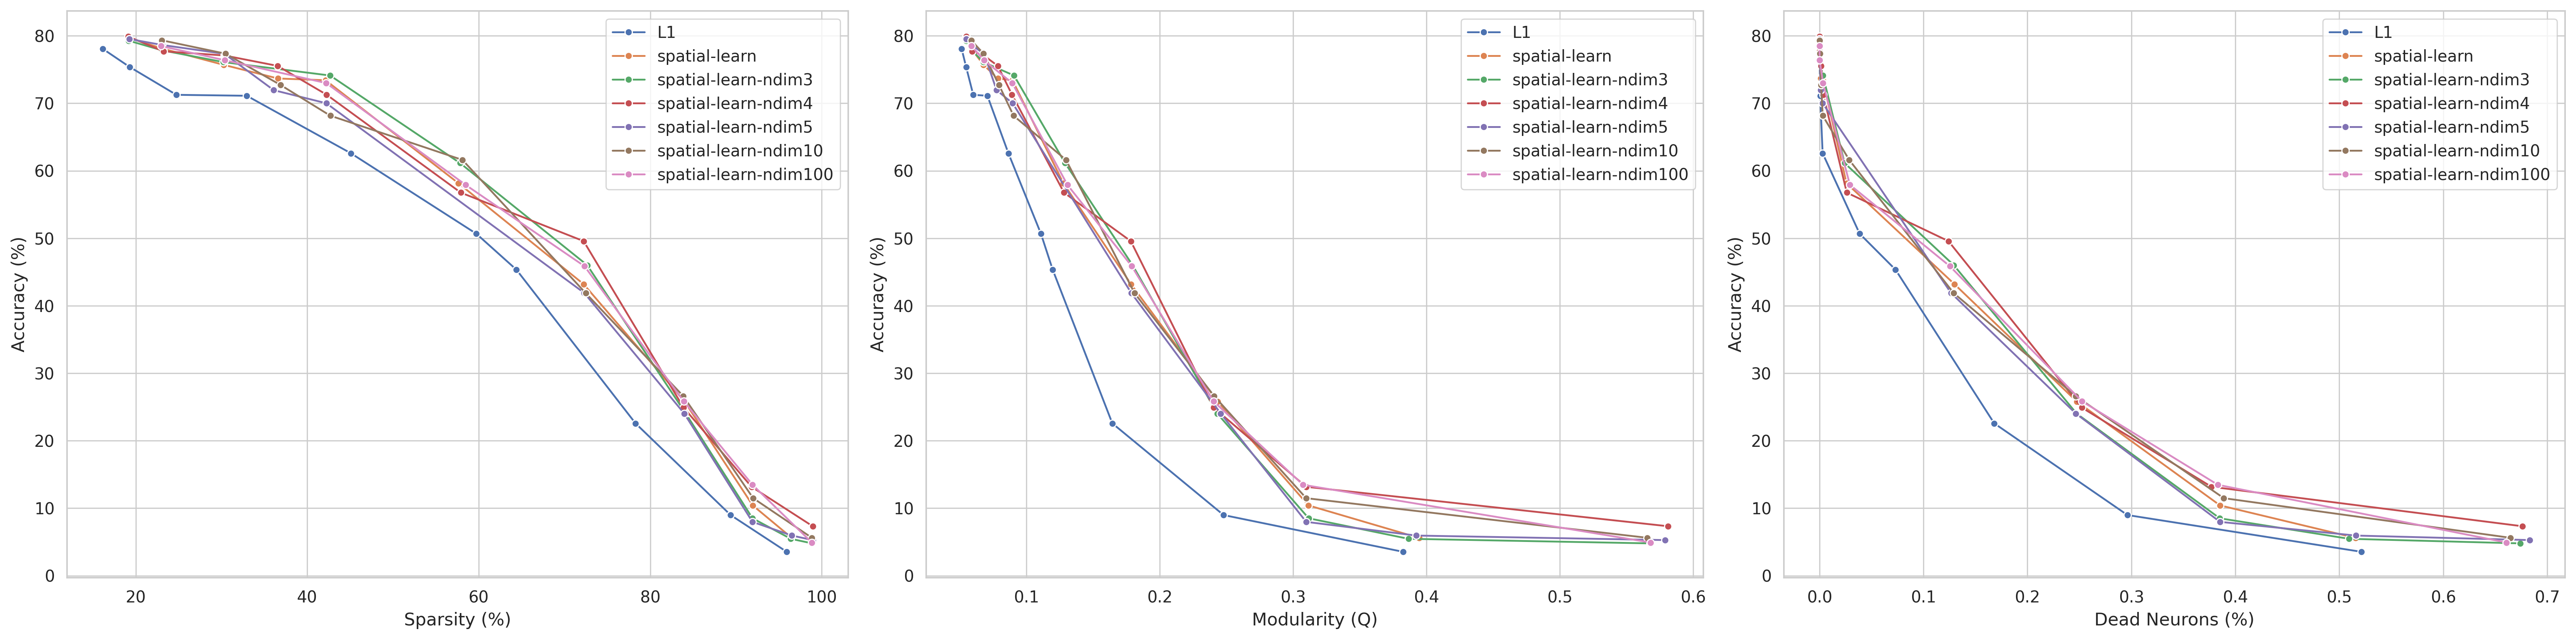

In [ ]:
import util
import glob
import timm
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import pickle
import os
from collections import defaultdict
from typing import List, Tuple

def pareto_front(points: List[Tuple[float, float]],negate_x=False,negate_y=False) -> List[Tuple[float, float]]:
    """
    Return the Pareto front from a list of 2D points.
    A point p is Pareto-optimal if no other point q satisfies:
      q.x >= p.x and q.y >= p.y, with at least one strict.
    """
    x = 1
    if negate_x:
        x=-1
    y=1
    if negate_y:
        y=-1
    front = []
    for p in points:
        # check if any other point dominates p
        dominated = False
        for q in points:
            if (x*q[0] >= x*p[0] and y*q[1] >= y*p[1]
                and (x*q[0] > x*p[0] or y*q[1] > y*p[1])):
                dominated = True
                break
        if not dominated:
            front.append(p)
    return front

def stringify_keys(obj):
    """
    Recursively convert all keys in a nested dict to strings.
    If values are lists or tuples, recurse into their elements.
    Other types are returned unchanged.
    """
    if isinstance(obj, dict):
        return {str(key): stringify_keys(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [stringify_keys(item) for item in obj]
    elif isinstance(obj, tuple):
        return tuple(stringify_keys(item) for item in obj)
    else:
        return obj


# datasets = ['cifar100','cifar10',"pets","tiny_imagenet"]#,
# datasets = ['svhn','birds','caltech101','DTD']
models = ["vit_tiny_patch16_224"]#,"resnet50"]


datasets = ['cifar100']
# models =["vit_tiny_patch16_224","resnet50",'vit_base_patch16_224','resnet101']#,'efficientnet_b0','vgg19','swin_base_patch4_window7_224','densenet121']#'mobilenetv3_small_100','visformer_small
# models = ['efficientnet_b0','vgg19','swin_base_patch4_window7_224','densenet121']
# datasets = ['cifar100','cifar10',"tiny_imagenet",'svhn']
# models = ["vit_tiny_patch16_224","resnet50"]

modes = {
    "baseline": [0],
    "L1" : [50, 200, 500, 1000, 2000, 4000, 5000, 10000, 20000, 40000],
    "spatial": [20,40,80,120,162,325,650,1300,2600,5000],
    "spatial-swap": [20,40,80,120,162,325,650,1300,2600,5000],
    "spatial-learn":[20,40,80,120,162,325,650,1300,2600,5000],
    "spatial-both": [20,40,80,120,162,325,650,1300,2600,5000],
    "uniform": [20,40,80,120,162,325,650,1300,2600,5000,10000,20000,40000],
    "gaussian": [20,40,80,120,162,325,650,1300,2600,5000,10000,20000,40000],
    "cluster4": [20,40,80,120,162,325,650,1300,2600,5000,10000,20000,40000],
    "cluster40": [20,40,80,120,162,325,650,1300,2600,5000,10000],
    "cluster400": [20,40,80,120,162,325,650,1300,2600,5000,10000],
    "spatial-learn-polar": [20,40,80,120,162,325,650,1300,2600,5000,10000],
    "spatial-squared": [1,2,3,5,10,15,20,40,80,120,162,325,650,1300,2600,5000,10000],
    "spatial-circle": [1,5,10,20,40,80,120,162,325,650,1300,2600,5000,10000],
    "spatial-learn-polar": [20,40,80,120,162,325,650,1300,2600,5000,10000,20000],
    "spatial-learn-euclidean": [20,40,80,120,162,325,650,1300,2600,5000,10000],
    "spatial-learn-ndim3": [20,40,80,120,162,325,650,1300,2600,5000,10000],
    "spatial-learn-ndim4": [20,40,80,120,162,325,650,1300,2600,5000,10000],
    "spatial-learn-ndim5": [20,40,80,120,162,325,650,1300,2600,5000,10000],
    "spatial-learn-ndim10": [20,40,80,120,162,325,650,1300,2600,5000,10000],
    "spatial-learn-ndim100": [20,40,80,120,162,325,650,1300,2600,5000,10000],
    "spatial-learn-squared": [1,2,3,5,10,15,20,40,80,120,162,325,650,1300,2600,5000,10000],

}


results = defaultdict(lambda:  defaultdict(lambda:  defaultdict(lambda: {})))
for dataset in datasets:
    for model in models:
        for mode, gammas in modes.items():
            for gamma in gammas:
                path = dataset +"/" + mode + "/" 
                file_name = mode + ":" +model+":"+str(gamma) 
                name = "./metrics/"+path+ file_name +'.pkl'
                if os.path.exists(name):
                    with open(name, 'rb') as f:
                        result = pickle.load(f)
                    result = stringify_keys(result)
                    results[dataset][model][mode][gamma]=result
                    #print("loaded",dataset,model,mode,gamma)

modes = [
    # "baseline",
    "L1",
    "spatial",
    # "spatial-swap",
    "spatial-learn",
    # "spatial-both",
    # "uniform",
    # "gaussian",
    # "cluster4",
    # "cluster40",
    # "cluster400",
    # "spatial-learn-polar",
    "spatial-squared",
    # "spatial-circle",
    # "spatial-learn-euclidean",
    # "spatial-learn-ndim3",
    # "spatial-learn-ndim4",
    # "spatial-learn-ndim5",
    # "spatial-learn-ndim10",
    # "spatial-learn-ndim100",
    "spatial-learn-squared",
]

pareto=True
combine_spatials=False
images=[]
for dataset in datasets:
    for model in models:

        y_axis = "final_acc"
        x_axis = "percent_below_t"#"percent_dead_neurons" # "modularity" # "percent_below_t"
        ylabel = "Accuracy (%)"
        xlabel = "Sparsity (%)"
        threshold = "0.001"
        # title = f"{dataset} {model}"
        title = ""
        lists=[]
        labels=[]
        for mode in modes:
            metrics=[]
            for gamma in results[dataset][model][mode].keys():
                try:
                    metrics.append((float((results[dataset][model][mode][gamma][threshold][y_axis])), float(results[dataset][model][mode][gamma][threshold][x_axis])))
                except:
                    print("empty", dataset,mode,model,gamma)
                    print(results[dataset][model][mode][gamma])
            if pareto:
                metrics =pareto_front(metrics)
            lists.append(metrics)
            labels.append(mode)
 
        if combine_spatials:
            l1 = lists[0]
            spatials = pareto_front(lists[1] + lists[2]+ lists[3] + lists[4])
            spatials = sorted(spatials, key=lambda x: x[1])

            lists=[l1,spatials]
            labels = ["L1","spatial"]


        sparse_acc_img = util.plot_lists(lists, title=title, xlabel=xlabel, ylabel=ylabel, labels=labels)


        lists=[]
        labels=[]
        for mode in modes:
            temp = []
            max_tuples=[]
            for p in [100,90,80,70,60,50,40,30,20,10,5,3,2,1]:
                gammas =  [x for x in results[dataset][model][mode].keys()]
                try:
                    temp = [(results[dataset][model][mode][gamma][str(p)][y_axis],100-p) for gamma in gammas]
                except:
                    pass
                    #print("empty", dataset,mode,model,gamma)
                if len(temp)==0:
                    continue
                max_tuple = max(temp, key=lambda x: x[0])
                max_tuples.append(max_tuple)
            if pareto:
                metrics =pareto_front(metrics)
            lists.append(max_tuples)
            labels.append(mode)
        if combine_spatials:
            l1 = lists[0]
            spatials = pareto_front(lists[1] + lists[2]+ lists[3] + lists[4])
            spatials = sorted(spatials, key=lambda x: x[1])

            lists=[l1,spatials]
            labels = ["L1","spatial"]
        spares_acc_max_img = util.plot_lists(lists, title=title, xlabel=xlabel, ylabel=ylabel, labels=labels)


        y_axis = "final_acc"
        x_axis = "percent_dead_neurons"#"percent_dead_neurons" # "modularity" # "percent_below_t"
        ylabel = "Accuracy (%)"
        xlabel = "Dead Neurons (%)"
        threshold = "0.001"
        #title = f"{dataset} {model}"

        lists=[]
        labels=[]
        for mode in modes:
            metrics=[]
            for gamma in results[dataset][model][mode].keys():
                try:
                    metrics.append((float((results[dataset][model][mode][gamma][threshold][y_axis])), float(results[dataset][model][mode][gamma][threshold][x_axis])))
                except:
                    pass
            if pareto:
                metrics =pareto_front(metrics)
            lists.append(metrics)
            labels.append(mode)
        if combine_spatials:
            l1 = lists[0]
            spatials = pareto_front(lists[1] + lists[2]+ lists[3] + lists[4])
            spatials = sorted(spatials, key=lambda x: x[1])

            lists=[l1,spatials]
            labels = ["L1","spatial"]
        dead_acc_img = util.plot_lists(lists, title=title, xlabel=xlabel, ylabel=ylabel, labels=labels)


        y_axis = "percent_below_t"
        x_axis = "percent_dead_neurons"#"percent_dead_neurons" # "modularity" # "percent_below_t"
        ylabel = "Sparsity (%)"
        xlabel = "Dead Neurons (%)"
        threshold = "0.001"
        # title = f"{dataset} {model}"

        lists=[]
        labels=[]
        for mode in modes:
            metrics=[]
            for gamma in results[dataset][model][mode].keys():
                try:
                    metrics.append((float((results[dataset][model][mode][gamma][threshold][y_axis])), float(results[dataset][model][mode][gamma][threshold][x_axis])))
                except:
                    pass
            lists.append(metrics)
            labels.append(mode)
        dead_sparse_img = util.plot_lists(lists, title=title, xlabel=xlabel, ylabel=ylabel, labels=labels)


        y_axis = "final_acc"
        x_axis = "modularity"#"percent_dead_neurons" # "modularity" # "percent_below_t"
        ylabel = "Accuracy (%)"
        xlabel = "Modularity (Q)"
        threshold = "0.001"
        # title = f"{dataset} {model}"

        lists=[]
        labels=[]
        for mode in modes:
            metrics=[]
            for gamma in results[dataset][model][mode].keys():
                try:
                    metrics.append((float((results[dataset][model][mode][gamma][threshold][y_axis])), float(results[dataset][model][mode][gamma][threshold][x_axis])))
                except:
                    pass

            if pareto:
                metrics =pareto_front(metrics)
            lists.append(metrics)
            labels.append(mode)
        if combine_spatials:
            l1 = lists[0]
            spatials = pareto_front(lists[1] + lists[2]+ lists[3] + lists[4])
            spatials = sorted(spatials, key=lambda x: x[1])

            lists=[l1,spatials]
            labels = ["L1","spatial"]
        modularity_acc_img = util.plot_lists(lists, title=title, xlabel=xlabel, ylabel=ylabel, labels=labels)


        y_axis = "percent_below_t"
        x_axis = "modularity"#"percent_dead_neurons" # "modularity" # "percent_below_t"
        ylabel = "Sparsity (%)"
        xlabel = "Modularity (Q)"
        threshold = "0.001"
        # title = f"{dataset} {model}"

        lists=[]
        labels=[]
        for mode in modes:
            metrics=[]
            for gamma in results[dataset][model][mode].keys():
                try:
                    metrics.append((float((results[dataset][model][mode][gamma][threshold][y_axis])), float(results[dataset][model][mode][gamma][threshold][x_axis])))
                except:
                    pass
            if pareto:
                metrics =pareto_front(metrics,negate_x=True)
            lists.append(metrics)
            labels.append(mode)
        if combine_spatials:
            l1 = lists[0]
            spatials = pareto_front(lists[1] + lists[2]+ lists[3] + lists[4],negate_x=True)
            spatials = sorted(spatials, key=lambda x: x[1])

            lists=[l1,spatials]
            labels = ["L1","spatial"]
        modularity_sparse_img = util.plot_lists(lists, title=title, xlabel=xlabel, ylabel=ylabel, labels=labels)


        y_axis = "shift_accuracy"
        x_axis = "percent_below_t"#"percent_dead_neurons" # "modularity" # "percent_below_t"
        ylabel = "Accuracy Under Distributional Shift (%)"
        xlabel = "Sparsity (%)"
        threshold = "0.001"
        # title = f"{dataset} {model}"

        lists=[]
        labels=[]
        for mode in modes:
            metrics=[]
            for gamma in results[dataset][model][mode].keys():
                try:
                    metrics.append((float((results[dataset][model][mode][gamma][threshold][y_axis])), float(results[dataset][model][mode][gamma][threshold][x_axis])))
                except:
                    pass
            lists.append(metrics)
            labels.append(mode)
        robust_sparse_img = util.plot_lists(lists, title=title, xlabel=xlabel, ylabel=ylabel, labels=labels)



        row = [sparse_acc_img,spares_acc_max_img]#, dead_acc_img,modularity_acc_img,modularity_sparse_img]
        row=[sparse_acc_img,spares_acc_max_img,modularity_acc_img,modularity_sparse_img,dead_acc_img]
        row=[sparse_acc_img,modularity_acc_img,dead_acc_img]

        images.append(row)
# util.make_image_grid([[image1,image2]])
row_titles =["VIT Tiny","resnet50"] + ['Vit','resnet101','efficientnet b0','vgg19','swin transformer','densenet121']#'mobilenetv3_small_100','visformer_small
col_titles = ["Pareto Front Fixed Threshold","Pareto Front Fixed Sparsity Level"]

                          

trans = []
for i in range(len(images[0])):
    r=[]
    for j in range(len(images)):
        r.append(images[j][i])
    trans.append(r)
util.make_image_grid(images)

In [2]:
! pip install seaborn